In [1]:
import cell2fate as c2f
import scanpy as sc
import numpy as np

Global seed set to 0


In [2]:
savings_directory = '/nfs/team283/aa16/data/cell2fate/trained_models/'

# Parameter settings for this run:
max_epochs = 1000
learning_rate = 0.01
batch_size = 1000
posterior_samples = 3

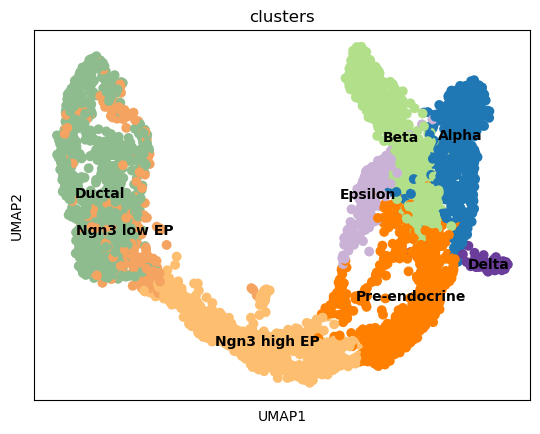

In [3]:
adata = sc.read_h5ad('/home/jupyter/data/benchmarking_datasets/Pancreas_with_cc/Pancreas_with_cc_anndata.h5ad')
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data')

Keeping at most 12500 cells per cluster
Filtered out 20801 genes that are detected 20 counts (shared).
Extracted 3000 highly variable genes.


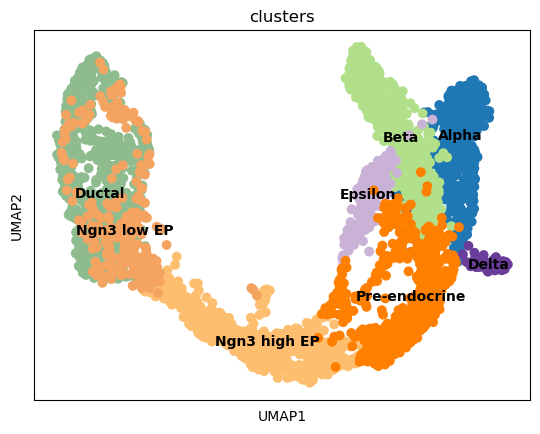

In [4]:
clusters_to_remove = []
n_clusters = len(adata.obs['clusters'].unique()) - len(clusters_to_remove)
adata = c2f.utils.get_training_data(adata, cells_per_cluster = int(np.round(100000/n_clusters)), cluster_column = 'clusters',
                                    remove_clusters = clusters_to_remove,
                                min_shared_counts = 20, n_var_genes = 3000)
sc.pl.umap(adata, color = 'clusters', s = 200, legend_loc='on data')

We register the anndata object and create the model instance as with other scvi-tools methods.

In [5]:
c2f.Cell2fate_ModularTranscriptionRate_model_SingleLineage_GlobalTime.setup_anndata(adata,
                                                                                    spliced_label='spliced',
                                                                                    unspliced_label='unspliced')

Get inital values for model parameters:

Initialize the model:

In [6]:
n_modules = 15
mod = c2f.Cell2fate_ModularTranscriptionRate_model_SingleLineage_GlobalTime(adata,
                                                       n_modules = n_modules)
                                                       # init_vals = init_vals)

In [7]:
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.1.

Setup via `Cell2fate_ModularTranscriptionRate_model_SingleLineage_GlobalTime.setup_anndata` 
with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'unspliced_label': 'unspliced',
│   'spliced_label': 'spliced',
│   'cluster_label': None
}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 3696  │
│      n_vars      │ 3000  │
│     n_batch      │   1   │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  unspliced   │ adata.layers['unspliced'] │
│   spliced    │  adata.layers['spliced']  │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

The lower the learning rate and the higher the number of iterations, the better the results. For example a learning rate of 0.001 and 100000 iterations will give slightly better results than here and a learning rate 0.1 and just 100 iterations will give slightly worse results, but has the upside of a very short training time.

In [ ]:
mod.train(use_gpu=True, batch_size = batch_size, max_epochs = max_epochs, lr = learning_rate)
# mod.train(use_gpu=True, batch_size = batch_size, max_epochs = 1, lr = 10**(-10)) # (For checking initial values)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 203/1000:  20%|██        | 202/1000 [07:41<30:12,  2.27s/it, v_num=1, elbo_train=1.15e+7]

We plot training history over multiple windows to effectively assess convergence (which is not reached here but it is close.)

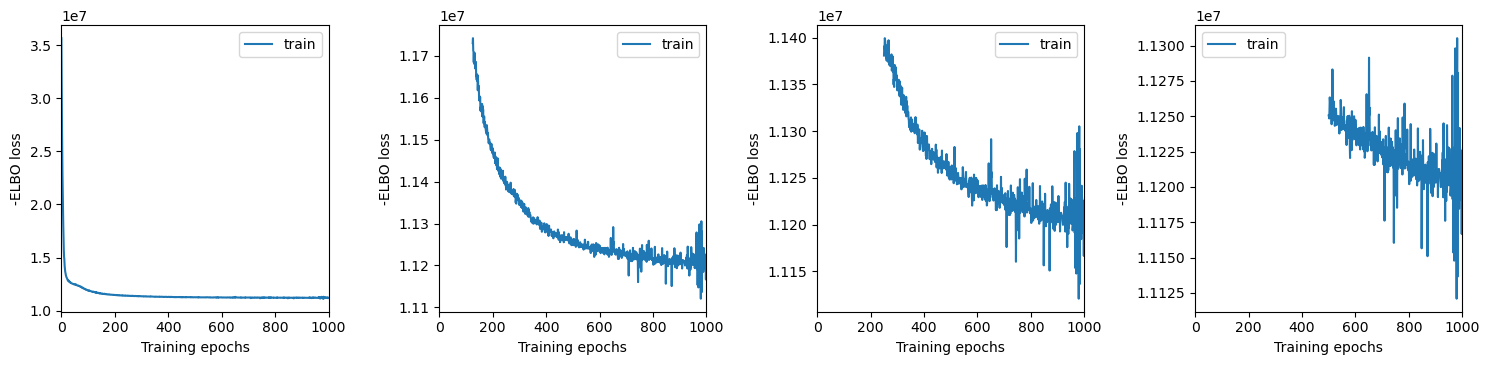

In [27]:
mod.max_epochs = max_epochs
mod.view_history()

Here we export the model posterior to the anndata object and calculate some useful quantities like RNAvelocity based on it.

In [ ]:
adata = mod.export_posterior(adata,
                 sample_kwargs = {"num_samples": posterior_samples, "batch_size" : adata.n_obs,
                                  "use_gpu" : True, 'return_samples': True},
                 full_velocity_posterior = False)

In [ ]:
# adata.obs['Time unconstrained space'] = mod.module.guide.locs.t_c_unconstrained[:,0,0].detach().numpy()

In [ ]:
# mod.module.guide._get_posterior_median('T_c',)

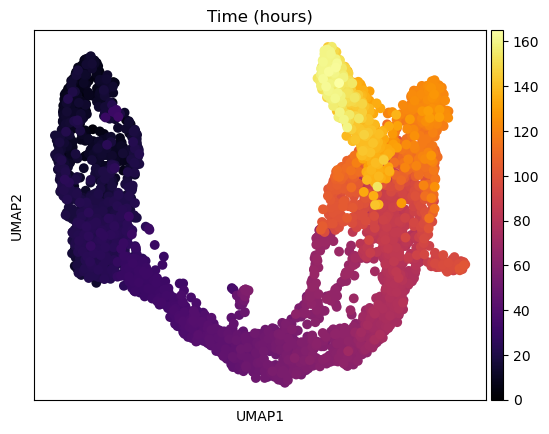

In [28]:
sc.pl.umap(adata, color = ['Time (hours)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2)

T_mON [[[  0.         6.174048  34.895397  45.08955   47.79356   58.552906
    66.71212   73.24201   77.50006   84.68853   94.91644  110.301704
   132.7694   173.27162  179.49641 ]]]
T_mOFF [[[ 32.853096  46.33553   58.28395  179.79431   65.00628   70.75082
    74.3586    83.85772   93.91476  109.880806 130.8856   173.54448
   178.08704  184.12791  188.31323 ]]]
Tmax 61.02341


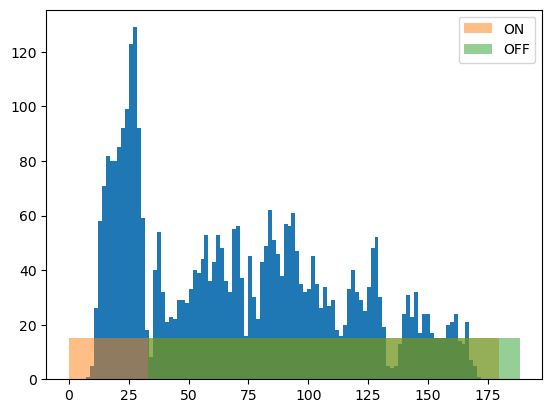

In [29]:
import matplotlib.pyplot as plt
plt.hist(mod.samples['post_sample_means']['T_c'].flatten(), bins = 100)
plt.hist(mod.samples['post_sample_means']['T_mON'].flatten(), bins = 1, alpha = 0.5, label = 'ON')
plt.hist(mod.samples['post_sample_means']['T_mOFF'].flatten(), bins = 1, alpha = 0.5, label = 'OFF')
plt.legend()
print('T_mON', mod.samples['post_sample_means']['T_mON'])
print('T_mOFF', mod.samples['post_sample_means']['T_mOFF'])
print('Tmax', mod.samples['post_sample_means']['Tmax'])

Could not find steady state. Increase interval or max_time_steps or decrease ss_fraction.


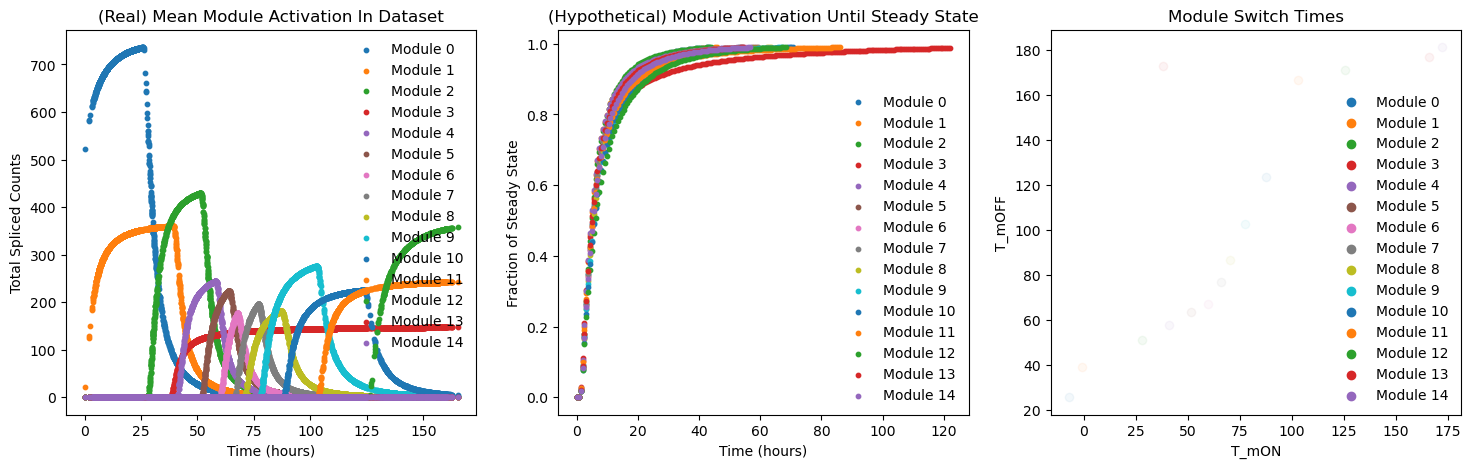

In [30]:
mod.compare_module_activation(adata, chosen_modules = [range(n_modules)], max_time_steps = 200, interval = 0.01)

In [ ]:
# adata.obs['spliced_log10_total'] = np.log10(np.sum(adata.layers['spliced'], axis = 1))
# adata.obs['unspliced_log10_total'] = np.log10(np.sum(adata.layers['unspliced'], axis = 1))
# adata.obs['spliced_total'] = np.sum(adata.layers['spliced'], axis = 1)
# adata.obs['unspliced_total'] = np.sum(adata.layers['unspliced'], axis = 1)
# adata.obs['unspliced_spliced_ratio'] = np.sum(adata.layers['unspliced'], axis = 1)/np.sum(adata.layers['spliced'], axis = 1)
# sc.pl.umap(adata, color = ['spliced_log10_total', 'unspliced_log10_total',
#                            'spliced_total', 'unspliced_total',
#                            'unspliced_spliced_ratio'],
#            legend_loc = 'right margin', size = 200, color_map = 'inferno', ncols = 2)

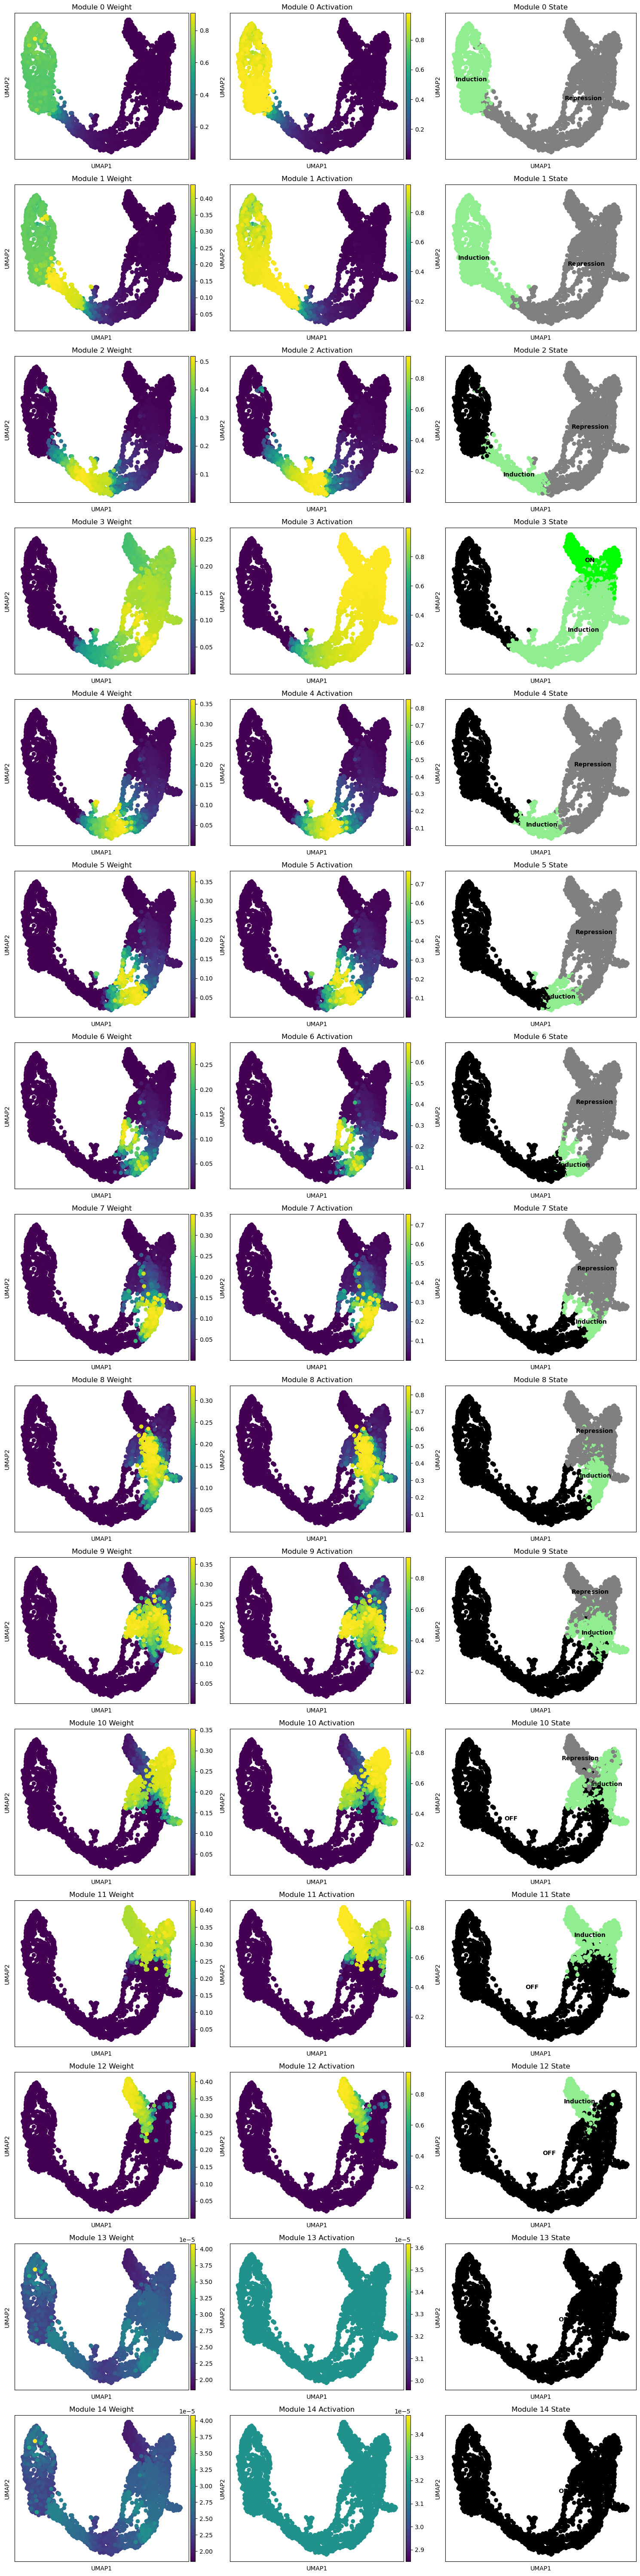

In [31]:
adata = mod.compute_module_summary_statistics(adata)
mod.plot_module_summary_statistics(adata)

In [ ]:
# for i in range(n_modules):
#     adata.obs['Module Weight']

In [ ]:
plt.hist(adata.obs['Module 0 Activation'])

Computing velocity produced by Module 0 ...
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
Computing velocity produced by Module 1 ...
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
Computing velocity produced by Module 2 ...
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
Computing velocity produced by Module 3 ...
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
Computing velocity produced by Module 4 ...
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
Computing velocity produced by Module 5 ...
computing neighbors
    finished (0:00:01) --> added 
    'distances' a

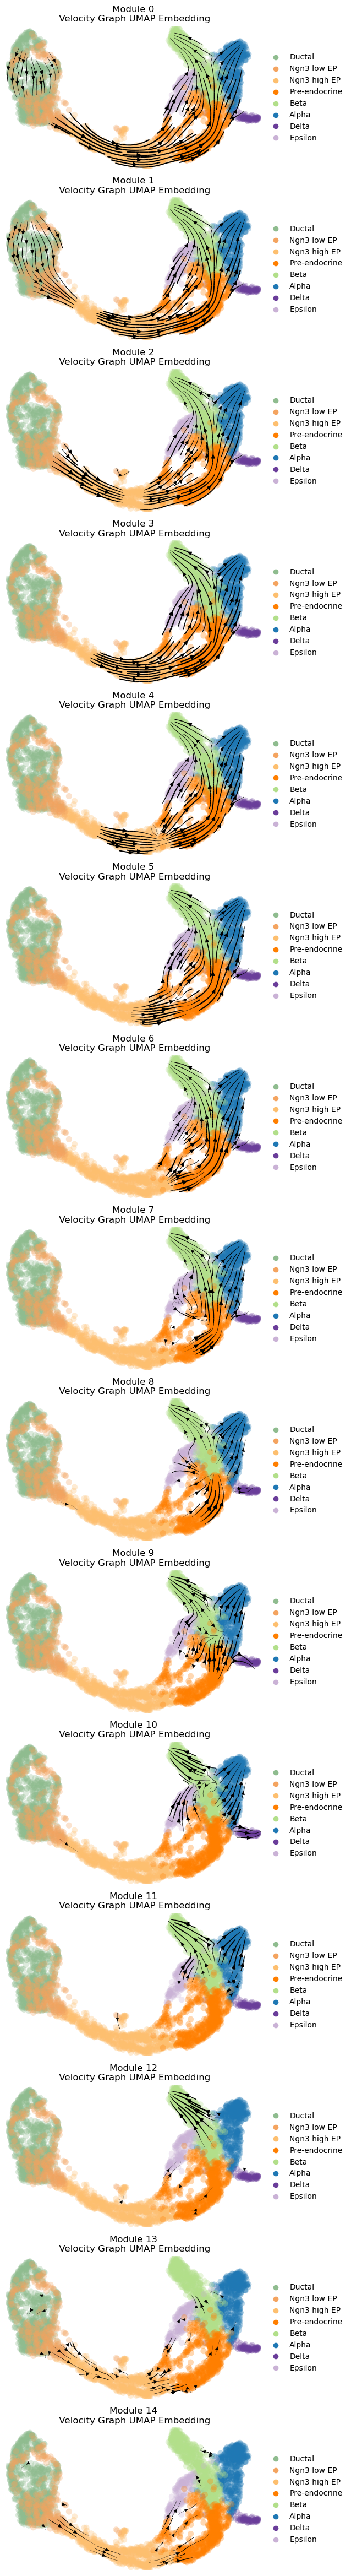

In [32]:
mod.compute_and_plot_module_velocity(adata)

In [ ]:
mod.compute_and_plot_total_velocity(adata)

Computing total RNAvelocity ...


In [ ]:
import matplotlib.pyplot as plt
plt.hist(np.sum(adata.layers['spliced'], axis = 1))

In [ ]:
plt.hist(mod.samples['post_sample_means']['T_c'].flatten() - np.min(mod.samples['post_sample_means']['T_c'].flatten()))

In [ ]:
mod.plot_technical_variables(adata)

In [ ]:
print('A_mgON mean:', np.mean(mod.samples['post_sample_means']['A_mgON']))
print('gamma_g mean:', np.mean(mod.samples['post_sample_means']['gamma_g']))
print('beta_g mean:', np.mean(mod.samples['post_sample_means']['beta_g']))
print('lam_mi, all modules: \n \n', np.round(mod.samples['post_sample_means']['lam_mi'],2))

In [ ]:
tab = mod.get_module_top_features(adata, p_adj_cutoff=0.1)
tab

In [ ]:
import scvelo as scv
scv.tl.score_genes_cell_cycle(adata)
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

This is how we can save the model and anndata object for later use:

In [ ]:
# # Make an interpretable name for this run:
# run_name = savings_directory + 'PancreasData' + '+Genes_' + str(len(adata.var_names)) + \
# '+Cells_' + str(len(adata.obs_names)) +  \
# '+Model_Cell2fate_ModularTranscriptionRate_NoSplicing_2' + '+Modules_' + str(max_modules) \
# + '+Lineages_' + str(max_lineages) + '+TrainingEpochs_' + str(max_epochs) \
# + '+LearningRate_' + str(learning_rate) + '+BatchSize_' + str(batch_size) + '+PosteriorSamples_' + str(posterior_samples)
# adata_file = run_name + "/anndata.h5ad"

In [ ]:
# # Save model:
# mod.save(f"{run_name}", overwrite=True)
# # Save adata object:
# adata.write(adata_file)

This is how we can load the model again:

In [ ]:
# adata = sc.read_h5ad(adata_file)
# mod = c2f.Cell2fate_ModularTranscriptionRate_FixedModules.load(f"{run_name}", adata)

In [ ]:
plt.hist(np.sum(mod.samples['post_sample_means']['mu_expression'], axis = 1), bins = 100)

In [ ]:
adata.obs['mu_expression_sum'] = np.log10(np.sum(np.sum(mod.samples['post_sample_means']['mu_expression'], axis = 1), axis = -1))
sc.pl.umap(adata, color = 'mu_expression_sum')

In [ ]:
plt.hist(I_cm[:,m])

In [ ]:
mod.model.guide